In [3]:
"""
Script: relation_extraction_kg_construction.ipynb

Description:
-------------
This Jupyter Notebook sets up a Docker environment to load a Neo4j database and construct a Knowledge Graph (KG) by:
- Extracting relations between dummy Q-numbers in Wikidata.
- Extracting relations between dummy URI terms in DBpedia.
- Constructing a KG in Neo4j.
- Exporting the constructed KG to a GraphML file.

Still to be done:
------------------
- Build a pipeline to extract Q-numbers (from Wikidata) and URIs (from DBpedia) corresponding to Dutch terms into a dictionary.
- On the basis of this dictionary, integrate concepts and relations of both Wikidata and DBpedia when building the KG.

How to Run This Notebook:
------------------------
1. Clone the repository and navigate to the project directory.

2. Set up the Neo4j Docker container:
   Ensure Docker is installed and running, then start a Neo4j container with the following command:

   docker run --name neo4j-container -p7474:7474 -p7687:7687 -p7473:7473 \
     -e NEO4J_AUTH=neo4j/mp_kg_rag_chat \
     -e NEO4J_PLUGINS='["apoc"]' \
     -e NEO4J_dbms_security_procedures_unrestricted='apoc.*' \
     -d neo4j

3. Create a Conda environment and install dependencies:

   If this is your first time setting up the environment, create and activate the STEM-KG Conda environment:
   
   conda create --name STEM-KG python=3.11
   conda activate STEM-KG

   Then, install all dependencies from requirements.yml:

   conda env update --file requirements.yml --prune

   If you have already created the environment before, simply activate it:

   conda activate STEM-KG

4. Setup and launch JupyterLab, and open this notebook:
   conda install ipykernel
   python -m ipykernel install --user --name STEM-KG --display-name "Python (STEM-KG)"
   jupyter lab

5. Run the notebook cells sequentially to:
   - Extract relations from Wikidata and DBpedia.
   - Construct the Neo4j Knowledge Graph (KG).
   - Export the KG to a GraphML file for visualization.

Where to Consult the Final KG:
------------------------------
a. View the colored interactive Neo4j graph database in your browser at:
  http://localhost:7474/browser/

  Use the following login credentials:
  - NEO4J_USER = "neo4j"
  - NEO4J_PASSWORD = "mp_kg_rag_chat"

  To explore the graph, run a Cypher query such as:
  MATCH (n) RETURN n LIMIT 100;

  This query retrieves and displays a sample of 100 nodes and their relationships.

b. Or open a simple black-and-white static graph for the exported GraphML file 
  by running the Dash app in the code below.

"""

import logging
import subprocess
import time
import sys
import csv
import re
import requests
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
from neo4j import GraphDatabase
from rdflib import Graph as rdflibGraph, RDF, URIRef

# Docker settings for neo4j-container:
# ----------------------------------------------------------------------
# docker run --name neo4j-container -p7474:7474 -p7687:7687 -p7473:7473 \
#   -e NEO4J_AUTH=neo4j/mp_kg_rag_chat \
#   -e NEO4J_PLUGINS='["apoc"]' \
#   -e NEO4J_dbms_security_procedures_unrestricted='apoc.*' \
#   -d neo4j
# -----------------------------------------------------------------------
# If this does not work (normally the first time), try with: -e NEO4J_AUTH=neo4j/neo4j
# Other useful docker commands:
# -----------------------------------
# docker ps
#
# docker rm -f neo4j-container
#
#
# To view the graph, surf to: http://localhost:7474/browser/
# (log in using the credentials). Once in the browser, run Cypher queries such as:
# MATCH (n) RETURN n LIMIT 100;
# to see the nodes and relationships.

# ------------------------------
# Configuration & Logging Setup
# ------------------------------
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Neo4j connection settings
NEO4J_URI = "bolt://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "mp_kg_rag_chat"  # set non-default password
NEO4J_DATABASE = "neo4j"  # default database

# ------------------------------
# Docker and Neo4j Environment Setup
# ------------------------------
def setup_docker_container():
    """
    Checks if the Neo4j Docker container exists and is running.
    If not, creates and starts a container with the necessary ports and authentication.
    """
    try:
        subprocess.run(["docker", "info"], check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    except Exception as e:
        logging.error("Docker daemon not accessible. Please ensure Docker is installed and running.")
        sys.exit(1)

    # Check if the container 'neo4j-container' exists.
    try:
        result = subprocess.run(
            ["docker", "ps", "-a", "--filter", "name=neo4j-container", "--format", "{{.Names}}"],
            check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
        )
        container_name = result.stdout.strip()
    except Exception as e:
        logging.error(f"Error checking docker container: {e}")
        sys.exit(1)

    if container_name == "":
        logging.info("Neo4j container not found. Creating a new one...")
        try:
            subprocess.run(
                [
                    "docker", "run", "--name", "neo4j-container",
                    "-p7474:7474", "-p7687:7687", "-p7473:7473",
                    "-e", "NEO4J_AUTH=neo4j/mp_kg_rag_chat",
                    "-e", "NEO4J_PLUGINS='[\"apoc\"]'",
                    "-e", "NEO4J_dbms_security_procedures_unrestricted='apoc.*'",
                    "-d", "neo4j"
                ],
                check=True
            )
            logging.info("Neo4j container created and started.")
        except Exception as e:
            logging.error(f"Error creating neo4j container: {e}")
            sys.exit(1)
    else:
        logging.info("Neo4j container already exists.")
        # Check if the container is running.
        try:
            result = subprocess.run(
                ["docker", "ps", "--filter", "name=neo4j-container", "--format", "{{.Names}}"],
                check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
            )
            running_container = result.stdout.strip()
            if running_container == "":
                logging.info("Neo4j container exists but is not running. Starting container...")
                subprocess.run(["docker", "start", "neo4j-container"], check=True)
                logging.info("Neo4j container started.")
            else:
                logging.info("Neo4j container is already running.")
        except Exception as e:
            logging.error(f"Error checking/starting neo4j container: {e}")
            sys.exit(1)

    logging.info("Waiting for Neo4j container to initialize...")
    time.sleep(10)
    logging.info("Assuming Neo4j container is ready.")

def wait_for_neo4j_connection(timeout=30):
    """
    Polls for a successful connection to Neo4j until timeout.
    Returns True if successful, False otherwise.
    """
    start_time = time.time()
    while True:
        try:
            driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
            driver.verify_connectivity()
            driver.close()
            return True
        except Exception as e:
            if time.time() - start_time > timeout:
                logging.error("Timeout waiting for Neo4j to be ready.")
                return False
            time.sleep(2)

def reset_neo4j_container():
    """
    Removes the existing Neo4j container and sets it up again.
    """
    logging.info("Resetting Neo4j container...")
    try:
        subprocess.run(["docker", "rm", "-f", "neo4j-container"], check=True)
        logging.info("Old Neo4j container removed.")
    except Exception as e:
        logging.error(f"Error removing container: {e}")
    setup_docker_container()

def wait_for_neo4j_ready(timeout=30):
    """
    Waits for Neo4j to become available. If not ready within timeout,
    resets the container and tries again.
    """
    if not wait_for_neo4j_connection(timeout=timeout):
        logging.info("Neo4j not ready after initial wait. Resetting container...")
        reset_neo4j_container()
        if not wait_for_neo4j_connection(timeout=timeout):
            logging.error("Neo4j still not ready after reset. Exiting.")
            sys.exit(1)

def ensure_password_changed():
    """
    Ensures that the password set at container launch works.
    """
    wait_for_neo4j_ready(timeout=30)
    try:
        driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
        driver.verify_connectivity()
        driver.close()
        logging.info("Connected successfully using password: %s", NEO4J_PASSWORD)
    except Exception as e:
        logging.error(f"Error ensuring password change: {e}")
        sys.exit(1)

def wipe_neo4j():
    """
    Deletes all existing nodes and relationships from the database,
    so each run starts with a fresh graph.
    """
    try:
        driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
        with driver.session(database=NEO4J_DATABASE) as session:
            session.run("MATCH (n) DETACH DELETE n")
        driver.close()
        logging.info("All existing data in Neo4j has been cleared.")
    except Exception as e:
        logging.error(f"Error clearing Neo4j database: {e}")
        sys.exit(1)

# ------------------------------
# Wikidata Query and CSV Saving
# ------------------------------
def query_wikidata():
    """
    Executes a SPARQL query against Wikidata and returns the results.
    """
    try:
        sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
        sparql.setQuery("""
SELECT DISTINCT ?concept ?conceptLabel ?relation ?relationLabel ?target ?targetLabel
WHERE
{
  VALUES ?concept {
    wd:Q3064499 wd:Q11376 wd:Q316995 wd:Q167509 wd:Q11579
    wd:Q17253 wd:Q6543389 wd:Q241349 wd:Q9128 wd:Q11457
    wd:Q2571297 wd:Q11353 wd:Q198320 wd:Q182103 wd:Q151885
    wd:Q1343157 wd:Q123065 wd:Q254650 wd:Q11455 wd:Q189670
    wd:Q80993 wd:Q240827 wd:Q193461 wd:Q11379 wd:Q777580
    wd:Q1420 wd:Q124398 wd:Q2751267 wd:Q197036 wd:Q135767
    wd:Q11423 wd:Q128163 wd:Q11377 wd:Q2843257 wd:Q125977
    wd:Q190871 wd:Q202398 wd:Q193949 wd:Q209690 wd:Q11463
    wd:Q11466 wd:Q1752457 wd:Q532 wd:Q148632 wd:Q19277
    wd:Q494350 wd:Q1510916 wd:Q843606

  }
  VALUES ?target {
    wd:Q3064499 wd:Q11376 wd:Q316995 wd:Q167509 wd:Q11579
    wd:Q17253 wd:Q6543389 wd:Q241349 wd:Q9128 wd:Q11457
    wd:Q2571297 wd:Q11353 wd:Q198320 wd:Q182103 wd:Q151885
    wd:Q1343157 wd:Q123065 wd:Q254650 wd:Q11455 wd:Q189670
    wd:Q80993 wd:Q240827 wd:Q193461 wd:Q11379 wd:Q777580
    wd:Q1420 wd:Q124398 wd:Q2751267 wd:Q197036 wd:Q135767
    wd:Q11423 wd:Q128163 wd:Q11377 wd:Q2843257 wd:Q125977
    wd:Q190871 wd:Q202398 wd:Q193949 wd:Q209690 wd:Q11463
    wd:Q11466 wd:Q1752457 wd:Q532 wd:Q148632 wd:Q19277
    wd:Q494350 wd:Q1510916 wd:Q843606
  }
  FILTER(?concept != ?target)
  ?concept ?relation ?target .
  FILTER(STRSTARTS(STR(?relation), "http://www.wikidata.org/prop/direct/P"))
  # Convert wdt:P#### -> wd:P####
  BIND(IRI(CONCAT("http://www.wikidata.org/entity/", SUBSTR(STR(?relation), STRLEN("http://www.wikidata.org/prop/direct/") + 1))) AS ?relationEntity)
  OPTIONAL {
    ?relationEntity rdfs:label ?propLabel .
    FILTER(LANG(?propLabel) = "en")
  }
  BIND(
    COALESCE(?propLabel, SUBSTR(STR(?relation), STRLEN("http://www.wikidata.org/prop/direct/") + 1))
    AS ?relationLabel
  )
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
        """)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        logging.info("Successfully queried Wikidata.")
        return results
    except Exception as e:
        logging.error(f"Error querying Wikidata: {e}")
        sys.exit(1)

def save_to_csv(results, filename="wikidata_relations.csv"):
    """
    Saves SPARQL query results to a CSV file.
    Returns a list of dictionaries for further processing.
    """
    try:
        data = []
        # For Wikidata we assume all needed fields exist
        for result in results["results"]["bindings"]:
            data.append({
                "concept": result["concept"]["value"].split("/")[-1],
                "conceptLabel": result["conceptLabel"]["value"],
                "relation": result["relation"]["value"].split("/")[-1],
                "relationLabel": result["relationLabel"]["value"],
                "target": result["target"]["value"].split("/")[-1],
                "targetLabel": result["targetLabel"]["value"]
            })
        df = pd.DataFrame(data)
        df.to_csv(filename, index=False)
        logging.info(f"Data successfully saved to {filename}.")
        return data
    except Exception as e:
        logging.error(f"Error saving data to CSV: {e}")
        sys.exit(1)

# ------------------------------
# DBpedia Helper Functions
# ------------------------------
def extract_local_name(uri):
    """
    Extracts the local name from a URI.
    If the URI contains a '#' fragment, returns the part after '#' else the last segment after '/'.
    """
    if '#' in uri:
        return uri.split('#')[-1].lower()
    else:
        return uri.rstrip('/').split('/')[-1].lower()

def clean_label(label):
    """
    Cleans a label string by extracting content within quotes and converting to lowercase.
    For example, '"Proton"@en' becomes 'proton'.
    """
    match = re.search(r'^"(.*?)"', label)
    if match:
        return match.group(1).lower()
    else:
        return label.lower()

def get_relation_type(relation_uri):
    """
    Retrieves an rdf:type for the given relation URI.
    Prefers types from the RDF namespace; if none, returns the local name of the relation URI.
    """
    headers = {'Accept': 'application/rdf+xml'}
    try:
        response = requests.get(relation_uri, headers=headers, timeout=10)
        if response.status_code == 200:
            g = rdflibGraph()
            g.parse(data=response.text, format='xml')
            all_types = list(g.objects(URIRef(relation_uri), RDF.type))
            for t in all_types:
                t_str = str(t)
                if t_str.startswith("http://www.w3.org/1999/02/22-rdf-syntax-ns#"):
                    local_name = t_str.split("#")[-1].lower()
                    return local_name
            if len(all_types) > 0:
                first_type = str(all_types[0])
                if "#" in first_type:
                    return first_type.split("#")[-1].lower()
                else:
                    return first_type.split("/")[-1].lower()
    except Exception as e:
        logging.error(f"Error retrieving relation type for {relation_uri}: {e}")
    return extract_local_name(relation_uri)

# ------------------------------
# DBpedia Query and CSV Saving
# ------------------------------
def query_dbpedia():
    """
    Executes a SPARQL query against the DBpedia endpoint, processes the results,
    saves them to a CSV file, and returns the data as a list of dictionaries.
    The returned dictionaries have the same keys as Wikidata’s for consistency.
    """
    sparql_query = """
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?concept ?conceptLabel ?relation ?relationLabel ?target ?targetLabel
WHERE {
  VALUES ?concept {
    dbr:Sine_function dbr:Frequency dbr:Period_%28physics%29 dbr:Amplitude dbr:Wave
    dbr:Electron dbr:Harmonic_oscillator dbr:Phase_%28waves%29 dbr:Light dbr:Sound
    dbr:Sound_pressure_level dbr:Logarithm dbr:Snell%27s_law dbr:Refractive_index dbr:Particle
    dbr:Exponential_growth dbr:Exponential_function dbr:Exponential_decay dbr:Work_%28physics%29
    dbr:Definite_integral dbr:Force dbr:Euclidean_vector dbr:Torque dbr:Energy
    dbr:Radiant_energy dbr:Nuclear_power dbr:Kinetic_energy dbr:Electric_power dbr:Chemical_energy
    dbr:Thermal_energy dbr:Mass dbr:Velocity dbr:Electric_charge dbr:Redox_reaction
    dbr:Electric_potential dbr:Energy_storage dbr:Galvanic_cell dbr:Energy_efficiency dbr:Chemical_reaction
    dbr:Heat dbr:Temperature dbr:Field_%28physics%29 dbr:Electric_field dbr:Magnetic_field
    dbr:Electron_configuration dbr:Alternating_current dbr:Direct_current_circuit dbr:Direct_current
  }
  VALUES ?target {
    dbr:Sine_function dbr:Frequency dbr:Period_%28physics%29 dbr:Amplitude dbr:Wave
    dbr:Electron dbr:Harmonic_oscillator dbr:Phase_%28waves%29 dbr:Light dbr:Sound
    dbr:Sound_pressure_level dbr:Logarithm dbr:Snell%27s_law dbr:Refractive_index dbr:Particle
    dbr:Exponential_growth dbr:Exponential_function dbr:Exponential_decay dbr:Work_%28physics%29
    dbr:Definite_integral dbr:Force dbr:Euclidean_vector dbr:Torque dbr:Energy
    dbr:Radiant_energy dbr:Nuclear_power dbr:Kinetic_energy dbr:Electric_power dbr:Chemical_energy
    dbr:Thermal_energy dbr:Mass dbr:Velocity dbr:Electric_charge dbr:Redox_reaction
    dbr:Electric_potential dbr:Energy_storage dbr:Galvanic_cell dbr:Energy_efficiency dbr:Chemical_reaction
    dbr:Heat dbr:Temperature dbr:Field_%28physics%29 dbr:Electric_field dbr:Magnetic_field
    dbr:Electron_configuration dbr:Alternating_current dbr:Direct_current_circuit dbr:Direct_current
  }
  FILTER(?concept != ?target)
  ?concept ?relation ?target .

  OPTIONAL { ?concept rdfs:label ?conceptLabel. FILTER (lang(?conceptLabel) = "en") }
  OPTIONAL { ?target rdfs:label ?targetLabel. FILTER (lang(?targetLabel) = "en") }
  OPTIONAL { ?relation rdfs:label ?relationLabel. FILTER (lang(?relationLabel) = "en") }
}
    """
    endpoint_url = "http://dbpedia.org/sparql"
    sparql = SPARQLWrapper(endpoint_url)
    sparql.setQuery(sparql_query)
    sparql.setReturnFormat(JSON)
    try:
        results = sparql.query().convert()
    except Exception as e:
        logging.error(f"Error querying DBpedia: {e}")
        sys.exit(1)
    
    data = []
    csv_filename = "dbpedia_relations.csv"
    try:
        with open(csv_filename, mode='w', newline='', encoding='utf-8') as csvfile:
            fieldnames = ["concept", "conceptLabel", "relation", "relationLabel", "target", "targetLabel"]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            
            for result in results["results"]["bindings"]:
                # Process concept
                concept_uri = result["concept"]["value"]
                concept = extract_local_name(concept_uri)
                concept_label_raw = result.get("conceptLabel", {}).get("value", "")
                conceptLabel = clean_label(concept_label_raw) if concept_label_raw else concept

                # Process target
                target_uri = result["target"]["value"]
                target = extract_local_name(target_uri)
                target_label_raw = result.get("targetLabel", {}).get("value", "")
                targetLabel = clean_label(target_label_raw) if target_label_raw else target

                # Process relation
                relation_uri = result["relation"]["value"]
                relation = extract_local_name(relation_uri)
                relation_label_raw = result.get("relationLabel", {}).get("value", "")
                if relation_label_raw:
                    if relation_label_raw.startswith("Link from"):
                        relationLabel = get_relation_type(relation_uri)
                    elif ":" in relation_label_raw:
                        relationLabel = relation_label_raw.split(":")[-1].lower()
                    else:
                        relationLabel = clean_label(relation_label_raw)
                else:
                    relationLabel = relation

                row = {
                    "concept": concept,
                    "conceptLabel": conceptLabel,
                    "relation": relation,
                    "relationLabel": relationLabel,
                    "target": target,
                    "targetLabel": targetLabel
                }
                writer.writerow(row)
                data.append(row)
        logging.info(f"DBpedia data successfully saved to {csv_filename}.")
        return data
    except Exception as e:
        logging.error(f"Error processing/saving DBpedia data: {e}")
        sys.exit(1)

# ------------------------------
# Neo4j Data Insertion and KG Construction
# ------------------------------
def insert_data_into_neo4j(data):
    """
    Inserts a list of dictionaries (each representing a relation between concepts)
    into the Neo4j database.
    """
    try:
        driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
    except Exception as e:
        logging.error(f"Error connecting to Neo4j: {e}")
        sys.exit(1)

    def insert_data_tx(tx, concept, conceptLabel, relation, relationLabel, target, targetLabel):
        query = """
        MERGE (c1:Concept {id: $concept})
        SET c1.name = $conceptLabel
        MERGE (c2:Concept {id: $target})
        SET c2.name = $targetLabel
        MERGE (c1)-[r:RELATION {id: $relation}]->(c2)
        SET r.name = $relationLabel
        """
        tx.run(query, concept=concept, conceptLabel=conceptLabel,
                      relation=relation, relationLabel=relationLabel,
                      target=target, targetLabel=targetLabel)

    try:
        with driver.session(database=NEO4J_DATABASE) as session:
            for row in data:
                session.execute_write(
                    insert_data_tx,
                    row["concept"], row["conceptLabel"],
                    row["relation"], row["relationLabel"],
                    row["target"], row["targetLabel"]
                )
        logging.info("Data successfully imported into Neo4j!")
    except Exception as e:
        logging.error(f"Error importing data into Neo4j: {e}")
    finally:
        driver.close()

def construct_knowledge_graph():
    """
    Constructs a dynamic knowledge graph by updating node labels and relationship types
    based on the 'name' properties. Uses APOC procedures.
    """
    try:
        driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
    except Exception as e:
        logging.error(f"Error connecting to Neo4J for constructing KG: {e}")
        sys.exit(1)

    try:
        with driver.session(database=NEO4J_DATABASE) as session:
            # Update Nodes: Add a dynamic label derived from each node's 'name' property.
            node_query = """
            MATCH (n:Concept)
            WHERE n.name IS NOT NULL
            WITH n, toUpper(apoc.text.replace(n.name, '[^A-Za-z0-9]', '')) AS newLabel
            CALL apoc.create.addLabels(n, [newLabel]) YIELD node
            RETURN count(node) AS nodes_updated
            """
            result_nodes = session.execute_write(lambda tx: tx.run(node_query).single())
            logging.info(f"Nodes updated with dynamic labels: {result_nodes['nodes_updated']}")

            # Update Relationships: Create new relationships with dynamic types and delete generic ones.
            rel_query = """
            MATCH ()-[r:RELATION]->()
            WHERE r.name IS NOT NULL
            WITH r, toUpper(apoc.text.replace(r.name, '[^A-Za-z0-9]', '')) AS newRelType
            CALL apoc.create.relationship(startNode(r), newRelType, properties(r), endNode(r)) YIELD rel
            WITH r, rel
            DELETE r
            RETURN count(rel) AS relationships_created
            """
            result_rels = session.execute_write(lambda tx: tx.run(rel_query).single())
            logging.info(f"Relationships created with dynamic types: {result_rels['relationships_created']}")
    except Exception as e:
        logging.error(f"Error constructing knowledge graph: {e}")
    finally:
        driver.close()

def export_graph_to_file(export_filename="exported_graph.graphml"):
    """
    Exports the entire graph to a GraphML file using APOC procedures.
    """
    try:
        driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
    except Exception as e:
        logging.error(f"Error connecting to Neo4j for export: {e}")
        sys.exit(1)

    try:
        with driver.session(database=NEO4J_DATABASE) as session:
            query = """
            CALL apoc.export.graphml.all(null, {stream:true}) YIELD data
            RETURN data
            """
            result = session.execute_write(lambda tx: tx.run(query).single())
            graphml_data = result["data"]
            with open(export_filename, "w", encoding="utf-8") as f:
                f.write(graphml_data)
            logging.info(f"Graph successfully exported to {export_filename}")
    except Exception as e:
        logging.error(f"Error exporting graph: {e}")
    finally:
        driver.close()

# ------------------------------
# Main Execution
# ------------------------------
def main():
    # Step 1: Setup Docker container and ensure Neo4j is running.
    setup_docker_container()
    ensure_password_changed()
    
    # Step 1.5: Clear the Neo4j database so each run starts fresh.
    wipe_neo4j()
    
    # Step 2: Query Wikidata, save results to CSV, and get data for insertion.
    wikidata_results = query_wikidata()
    wikidata_data = save_to_csv(wikidata_results, filename="wikidata_relations.csv")
    
    # Step 3: Query DBpedia, save results to CSV, and get data for insertion.
    dbpedia_data = query_dbpedia()
    
    # Step 4: Insert both Wikidata and DBpedia data into Neo4j.
    if wikidata_data:
        insert_data_into_neo4j(wikidata_data)
    if dbpedia_data:
        insert_data_into_neo4j(dbpedia_data)
        
    # Step 5: Construct the dynamic knowledge graph.
    construct_knowledge_graph()
    
    # Step 6: Export the constructed graph to a GraphML file.
    export_graph_to_file()

if __name__ == "__main__":
    main()


2025-03-07 15:42:27,817 - INFO - Neo4j container already exists.
2025-03-07 15:42:27,962 - INFO - Neo4j container is already running.
2025-03-07 15:42:27,964 - INFO - Waiting for Neo4j container to initialize...
2025-03-07 15:42:37,970 - INFO - Assuming Neo4j container is ready.
2025-03-07 15:42:37,994 - INFO - Connected successfully using password: mp_kg_rag_chat
2025-03-07 15:42:38,014 - INFO - All existing data in Neo4j has been cleared.
2025-03-07 15:42:38,139 - INFO - Successfully queried Wikidata.
2025-03-07 15:42:38,146 - INFO - Data successfully saved to wikidata_relations.csv.
2025-03-07 15:43:37,693 - INFO - DBpedia data successfully saved to dbpedia_relations.csv.
2025-03-07 15:43:37,722 - INFO - Data successfully imported into Neo4j!
2025-03-07 15:43:38,476 - INFO - Data successfully imported into Neo4j!
2025-03-07 15:43:38,493 - INFO - Nodes updated with dynamic labels: 42
2025-03-07 15:43:38,504 - INFO - Relationships created with dynamic types: 214
2025-03-07 15:43:38,51

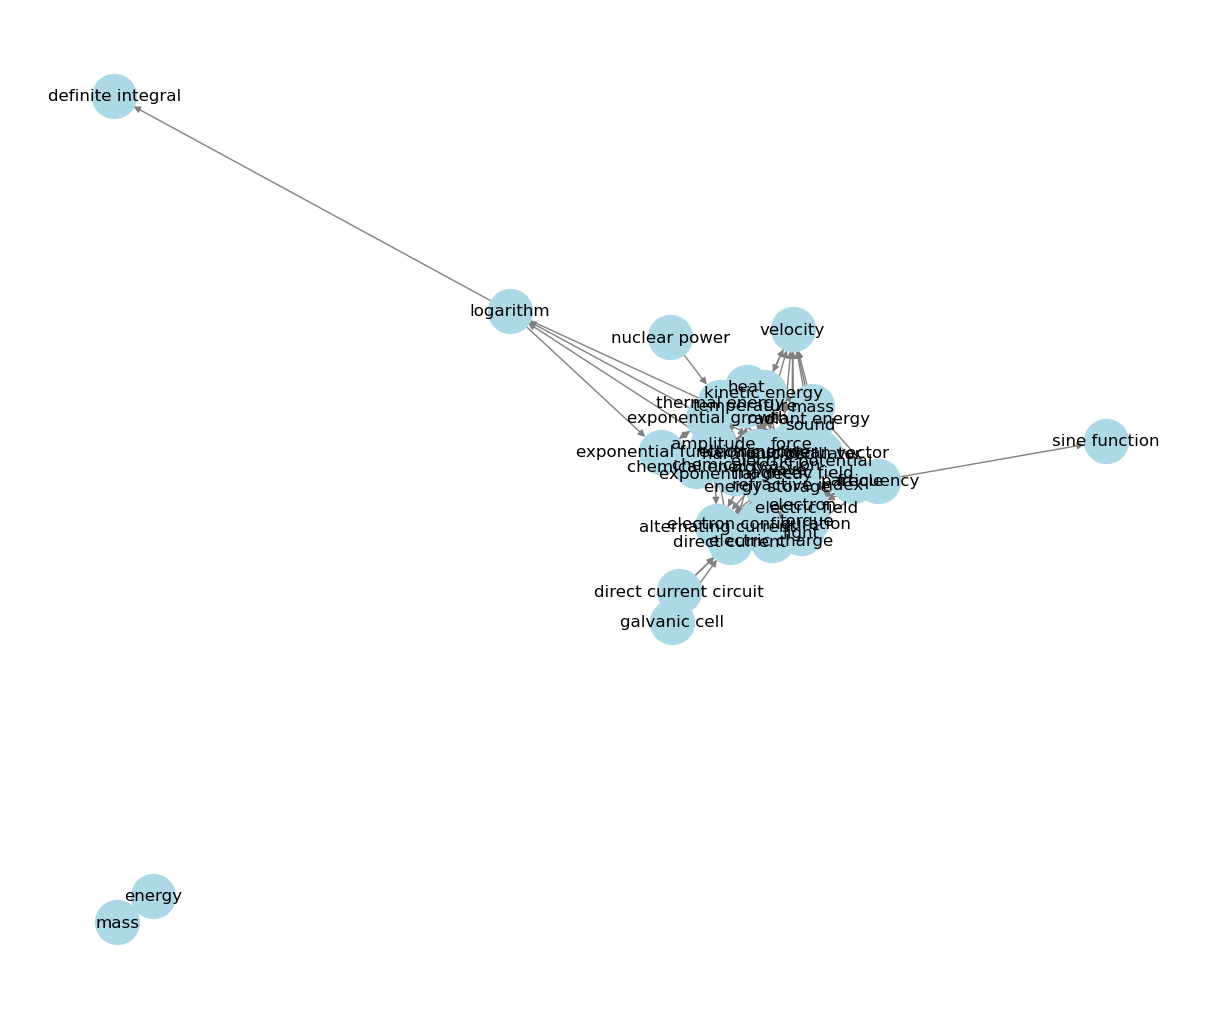

In [4]:
import dash
import dash_cytoscape as cyto
from dash import html
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display

def nx_to_elements(G):
    nodes = [{'data': {'id': str(n), 'label': G.nodes[n].get('name', str(n))}} for n in G.nodes()]
    edges = [{'data': {'source': str(u), 'target': str(v)}} for u, v in G.edges()]
    return nodes + edges

# Load graph
G = nx.read_graphml("exported_graph.graphml")

# Display in notebook
display(G)

# Define figure size
plt.figure(figsize=(12, 10))

# Set layout
pos = nx.spring_layout(G, seed=42)

# Draw nodes and edges
nx.draw(G, pos, with_labels=False, node_size=1000, node_color='lightblue', edge_color='gray')

# Add node labels explicitly
node_labels = {node: G.nodes[node].get('name', node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_color='black')

# # Add edge labels 
# edge_labels = {(u, v): f"{u}→{v}" for u, v in G.edges()}
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='red')

# Ensure labels are saved in PNG
plt.savefig("graph_visualization.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()
